# Visual QA, Coeus

### Project for the deep learning course 2021/2022 held by professor Fabrizio Silvestri.

## Dataset, read and analysis

this code comes partially from the original implementation https://github.com/GT-Vision-Lab/VQA, it helps in reading the json files from the dataset and creating a class to quickly retrieve the annotations of each <question, image> pair. Here we also perform the preprocessing needed for evaluation and on which we build all our work, since it is useful to build the vocab. 

In [1]:
import json
import datetime
import copy
import matplotlib.pyplot as plt
from PIL import Image
import re
from collections import OrderedDict, Counter
#TODO import + add seed things + git clone stuff for colab 
class VQA:
	def __init__(self, annotations_file: str, questions_file: str, images_semi_path: str, remove_mult_ans: bool, limit_size: int):
		self.proprocess_init()
		dataset = json.load(open(annotations_file, 'r'))
		questions = json.load(open(questions_file, 'r'))
		qa = dict()
		qqa = dict()
		# total number of questions
		self.n_tot = 0
		# number of answers with more than a word
		self.n_mul = 0
		# counter for the length of each answer, to understand if a baseline that produce one-word ans is feasible
		self.c_len = Counter()
		for ann in dataset['annotations']:
			self.n_tot += 1
			if self.n_tot > limit_size:
				break
			qid = ann['question_id']
			qatmp = ann
			qatmp["multiple_choice_answer"] = self.preprocess(
				qatmp["multiple_choice_answer"])
			ln = len(qatmp["multiple_choice_answer"].split())
			self.c_len.update([ln])
			if ln > 1:
				self.n_mul += 1
				if remove_mult_ans:
					continue
			qa[qid] = qatmp
			for i in range(10):
				qa[qid]["answers"][i]["answer"] = self.preprocess(
					qa[qid]["answers"][i]["answer"])
		for ques in questions['questions']:
			qid = ques['question_id']
			if qa.get(qid, "N") == "N":
				continue
			qqa[qid] = ques
			qqa[qid]["question"] = self.preprocess(qqa[qid]["question"])
		self.qa = qa
		self.qqa = qqa
		self.images_semi_path = images_semi_path

	def get_img_from_id(self, img_id):
		ids = str(img_id)
		# small trick to retrive the path from the id
		return self.images_semi_path+"0"*(12-len(ids))+ids+".jpg"

	def proprocess_init(self):
		# this function just set the utilities for the preprocessing
		self.contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't",
                      "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't",
                      "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've",
                      "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've",
                      "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's",
                      "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've",
                      "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't",
                      "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've",
                      "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've",
                      "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll",
                      "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've",
                      "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've",
                      "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've",
                      "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've",
                      "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't",
                      "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're",
                      "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've",
                      "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll",
                      "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've",
                      "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've",
                      "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've",
                      "youll": "you'll", "youre": "you're", "youve": "you've"}
		self.manualMap = {'none': '0',
                   'zero': '0',
                   'one': '1',
                   'two': '2',
                   'three': '3',
                   'four': '4',
                   'five': '5',
                   'six': '6',
                   'seven': '7',
                   'eight': '8',
                   'nine': '9',
                   'ten': '10'
                   }
		self.articles = ['a', 'an', 'the']
		self.periodStrip = re.compile("(?!<=\d)(\.)(?!\d)")
		self.commaStrip = re.compile("(\d)(\,)(\d)")
		self.punct = [';', r"/", '[', ']', '"', '{', '}',
						'(', ')', '=', '+', '\\', '_', '-',
						'>', '<', '@', '`', ',', '?', '!']

	def preprocess(self, sentence):
		sentence = sentence.lower()
		sentence = sentence.replace('\n', ' ')
		sentence = sentence.replace('\t', ' ')
		sentence = sentence.strip()
		ls = sentence.split()
		ws = []
		for w in ls:
			w = self.processPunctuation(w)
			w = self.processDigitArticle(w)
			ws += [w]
		return " ".join(ws)

	def processPunctuation(self, inText):
		outText = inText
		for p in self.punct:
			if (p + ' ' in inText or ' ' + p in inText) or (re.search(self.commaStrip, inText) != None):
				outText = outText.replace(p, '')
			else:
				outText = outText.replace(p, ' ')
		outText = self.periodStrip.sub("",
                                 outText,
                                 re.UNICODE)
		return outText

	def processDigitArticle(self, inText):
		outText = []
		tempText = inText.lower().split()
		for word in tempText:
			word = self.manualMap.setdefault(word, word)
			if word not in self.articles:
				outText.append(word)
			else:
				pass
		for wordId, word in enumerate(outText):
			if word in self.contractions:
				outText[wordId] = self.contractions[word]
		outText = ' '.join(outText)
		return outText

annotations_file = "datasets/v2_mscoco_train2014_annotations.json"
questions_file = "datasets/v2_OpenEnded_mscoco_train2014_questions.json"
images_semi_path = "datasets/train2014/COCO_train2014_"  # 000000000009.jpg
train_VQA = VQA(annotations_file, questions_file,
                images_semi_path, remove_mult_ans=True, limit_size=10000)


now we test the above class, with the aim to understand the structure for which we are working on

### Data Analysis

131366000

{'answer_type': 'number', 'multiple_choice_answer': '4', 'answers': [{'answer': '2', 'answer_confidence': 'maybe', 'answer_id': 1}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': '4', 'answer_confidence': 'maybe', 'answer_id': 3}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 6}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': '4', 'answer_confidence': 'yes', 'answer_id': 10}], 'image_id': 131366, 'question_type': 'how many people are', 'question_id': 131366000}

datasets/train2014/COCO_train2014_000000131366.jpg



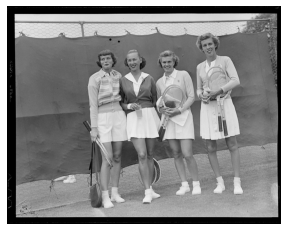

QUESTION
how many people are standing next to each other
MOST COMMON ANSWER
4


In [2]:
# let's see if it works
q = 131366000
print(q)
print()
# print the question
print(train_VQA.qa[q])
print()
img_id = train_VQA.qqa[q]["image_id"]
img_pth = train_VQA.get_img_from_id(img_id)
print(img_pth)
print()

img = Image.open(img_pth).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()
print("QUESTION")
print(train_VQA.qqa[q]["question"])
print("MOST COMMON ANSWER")
print(train_VQA.qa[q]["multiple_choice_answer"])


In [3]:
# let's make the vocabs
qst_v = Counter()
ans_v = Counter()

for k in train_VQA.qa:
    qst_v.update(train_VQA.qqa[k]["question"].split())
    ans_v.update(train_VQA.qa[k]["multiple_choice_answer"].split())

print(qst_v.most_common(10))
print(ans_v.most_common(10))


def build_vocab(counter, size):
    w2id = {}
    id2w = {}
    for idx, (i, _) in enumerate(counter.most_common(size)):
        w2id[i] = idx
        id2w[idx] = i
    w2id["OOV"] = idx+1
    id2w[idx+1] = "OOV"
    w2id["PAD"] = idx+2
    id2w[idx+2] = "PAD"
    return w2id, id2w


# vocabularies size as in the paper
qv_size = 1000
av_size = 1000

qv_w2id, qv_id2w = build_vocab(qst_v, qv_size)
av_w2id, av_id2w = build_vocab(ans_v, av_size)

print(av_w2id["yes"])
print(av_id2w[1001])

[('is', 5730), ('what', 3761), ('are', 2264), ('this', 1817), ('in', 1460), ('on', 1336), ('of', 1222), ('how', 1174), ('many', 1117), ('color', 1017)]
[('yes', 1930), ('no', 1761), ('1', 282), ('2', 241), ('white', 187), ('3', 170), ('0', 151), ('blue', 135), ('black', 135), ('red', 125)]
0
PAD


In [4]:
import random
import numpy as np

def one_group_bar(columns, data, title, percentage=True):
  labels = columns
  data = data[0]
  color_list = []
  for _ in range(len(data)):
    color = [random.randrange(0, 255)/255, random.randrange(0, 255)/255, random.randrange(0, 255)/255, 1]
    color_list.append(color)
  x = np.arange(len(labels))
  width = 0.5  # the width of the bars
  fig, ax = plt.subplots(figsize=(12, 5), layout='constrained')
  rects = ax.bar(x, data, width, color=color_list)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_title(title)
  ax.set_xticks(x, labels)
  if percentage:
    rects_labels = [('%.2f' % i) + "%" for i in data]
  else:
    rects_labels = data
  ax.bar_label(rects, rects_labels, padding=3)

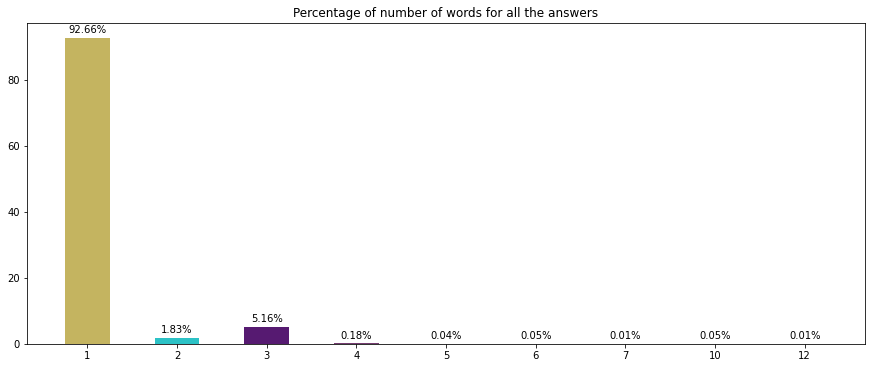

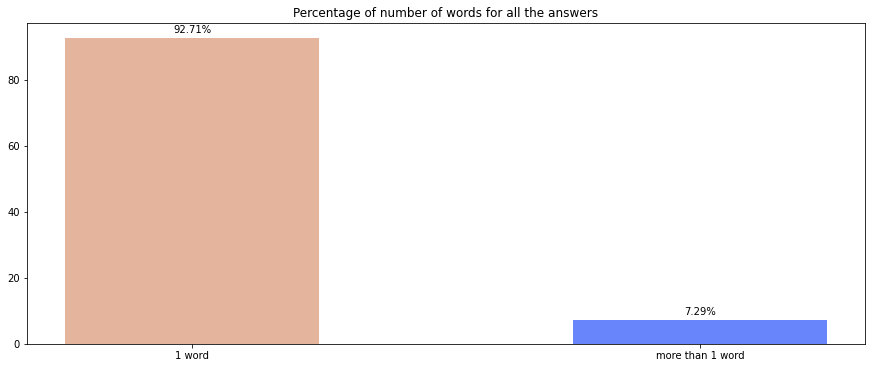

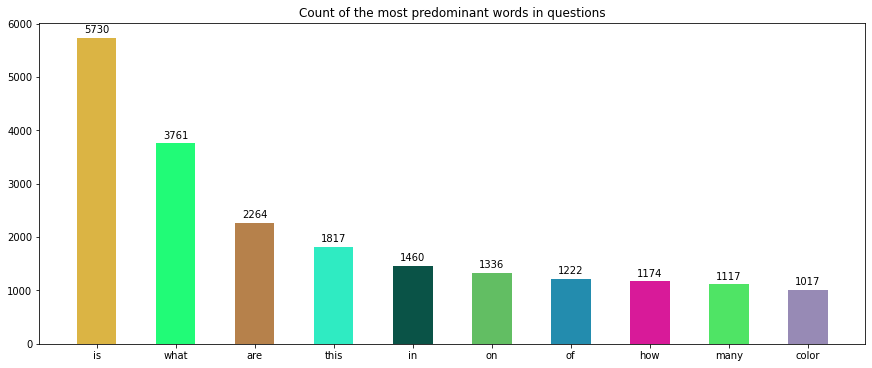

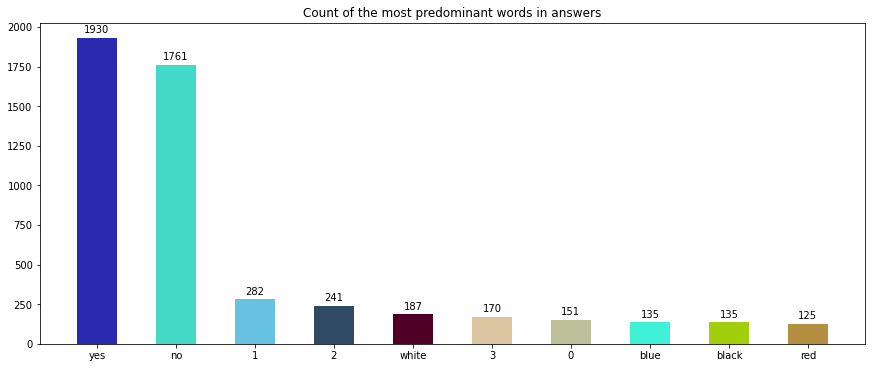

In [5]:
total_number_questions = train_VQA.n_tot
number_questions_more_one_word = train_VQA.n_mul
number_questions_one_word = total_number_questions - number_questions_more_one_word
## 1
columns = sorted([e+1 for e in list(train_VQA.c_len.keys())])
table_data = list(train_VQA.c_len.values())
table_data_percentage = []
table_data_percentage.append([(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, table_data_percentage, "Percentage of number of words for all the answers")

## 2
columns = ["1 word", "more than 1 word"]
table_data = [number_questions_one_word, number_questions_more_one_word]
table_data_percentage = []
table_data_percentage.append([(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, table_data_percentage, "Percentage of number of words for all the answers")

## 3
q_most_common_words = qst_v.most_common(10)
columns = [e[0] for e in q_most_common_words]
table_data = [e[1] for e in q_most_common_words]
one_group_bar(columns, [table_data], "Count of the most predominant words in questions", False)

## 4
a_most_common_words = ans_v.most_common(10)
columns = [e[0] for e in a_most_common_words]
table_data = [e[1] for e in a_most_common_words]
table_data_percentage = []
table_data_percentage.append([(elem/total_number_questions)*100 for elem in table_data])
one_group_bar(columns, [table_data], "Count of the most predominant words in answers", False)

## Dataset

In [6]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, List, Any, Dict, Optional
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from PIL import Image
from dataclasses import dataclass, asdict
from torchvision import transforms


@dataclass
class HParams():
    # dataset stuff
    batch_size: int = 256
    n_cpu: int = 8
    qv_size: int = 1000 #+1 for oov +1 for pad
    av_size: int = 1000 #+1 for oov +1 for pad
    lr: int = 3e-4
    wd: int = 0
    word_emb_dim: int = 300 #output of the word-embedding
    lstm_hidden_dim: int = 512
    lstm_num_layers: int = 2
    output_dim: int = 1024
    bidirectional: bool = False
    dropout: float = 0.3
    trainable_embeddings: bool = True

hparams = asdict(HParams())

class VQA_Dataset(Dataset):
    def __init__(self, VQA, qv_w2id, av_w2id):
        self.data = self.make_data(VQA, qv_w2id, av_w2id)

    def make_data(self, VQA, qv_w2id, av_w2id):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            # https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
            transforms.ToTensor(),
        ])
        data = list()
        qv_l = len(qv_w2id.keys())-2 #we remove oov and pad
        av_l = len(av_w2id.keys())-2
        # efficient handling of the images
        imgs = dict()
        for k in VQA.qa:
            # we build for each question the item <qst, img, ans> for the training phase
            item = dict()
            item["id"] = k
            item["question"] = [qv_w2id.get(w, qv_l)
                             for w in VQA.qqa[k]['question'].split()]
            img_id = VQA.qqa[k]["image_id"]
            img_pth = VQA.get_img_from_id(img_id)
            imgs[img_id] = imgs.get(img_id, Image.open(img_pth).convert('RGB'))
            item["img"] = transform(imgs[img_id])
            if (item["img"].shape[0] < 3):
                print(k)
            item["answer"] = torch.as_tensor(av_w2id.get(
                VQA.qa[k]["multiple_choice_answer"], av_l))
            data.append(item)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class VQA_DataModule(pl.LightningDataModule):
    def __init__(self, hparams: dict, train_VQA: Any, val_VQA: Any, qv_w2id: dict, qv_id2w: dict, av_w2id: dict, av_id2w: dict) -> None:
        super().__init__()
        self.save_hyperparameters(hparams)
        self.train_VQA = train_VQA
        self.val_VQA = val_VQA
        self.qv_w2id = qv_w2id
        self.qv_id2w = qv_id2w
        self.av_w2id = av_w2id
        self.av_id2w = av_id2w

    def setup(self, stage: Optional[str] = None) -> None:
        self.data_train = VQA_Dataset(
            self.train_VQA, self.qv_w2id, self.av_w2id)
        self.data_val = VQA_Dataset(self.val_VQA, self.qv_w2id, self.av_w2id)

    def train_dataloader(self):
        # change collate based on the task
        return DataLoader(
            self.data_train,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=True,
            persistent_workers=True
        )

    def val_dataloader(self):
        # change collate based on the task
        return DataLoader(
            self.data_val,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.n_cpu,
            collate_fn=self.collate,
            pin_memory=True,
            persistent_workers=True
        )

    def collate(self, batch):
        batch_out = dict()
        batch_out["id"] = [sample["id"] for sample in batch]
        batch_out["answer"] = torch.as_tensor(
            [sample["answer"] for sample in batch])
        batch_out["img"] = torch.stack(
            [sample["img"] for sample in batch], dim=0)
        batch_out["question"] = pad_sequence(
            [torch.as_tensor(sample["question"]) for sample in batch],
            batch_first=True,
            padding_value=self.hparams.qv_size+1
        )
        return batch_out


In [7]:
annotations_file_val = "datasets/v2_mscoco_val2014_annotations.json"
questions_file_val = "datasets/v2_OpenEnded_mscoco_val2014_questions.json"
images_semi_path_val = "datasets/val2014/COCO_val2014_"

val_VQA = VQA(annotations_file_val, questions_file_val, images_semi_path_val, remove_mult_ans=False, limit_size=1000)

In [8]:
data = VQA_DataModule(hparams, train_VQA, val_VQA, qv_w2id, qv_id2w, av_w2id, av_id2w)

## Model

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn, optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import models
# this baseline comes from the paper "1505.00468", it uses lstm+cnn to predict the final one-word answer.
class VQA_Baseline(pl.LightningModule):
    def __init__(self, hparams: dict) -> None:
        super(VQA_Baseline, self).__init__()
        self.save_hyperparameters(hparams)
        self.cnn = models.vgg16(pretrained=True)
        # we freeze the features extractor of the cnn
        for params in self.cnn.features.parameters():
            params.requires_grad = False
        # we freeze the first layer of the classifier because has >102M params
        for params in self.cnn.classifier[0].parameters():
            params.requires_grad = False
        # we remove the last linear layer to be consistent with the authors
        self.cnn.classifier=self.cnn.classifier[:-1]
        self.mlp1 = nn.Linear(4096, self.hparams.output_dim) #1024
        self.word_emb = nn.Embedding(self.hparams.qv_size+2, self.hparams.word_emb_dim, padding_idx=self.hparams.qv_size+1)
        self.lstm = nn.LSTM(self.hparams.word_emb_dim, self.hparams.lstm_hidden_dim,
                            bidirectional = self.hparams.bidirectional,
                            num_layers = self.hparams.lstm_num_layers,
                            dropout = self.hparams.dropout if self.hparams.lstm_num_layers > 1 else 0,
                            batch_first = True,
                            )
        lstm_output_dim = self.hparams.lstm_hidden_dim if self.hparams.bidirectional is False else self.hparams.lstm_hidden_dim * 2
        lstm_emb_dim = 2*lstm_output_dim*self.hparams.lstm_num_layers
        self.dropout = nn.Dropout(self.hparams.dropout)
        self.mlp2 = nn.Linear(lstm_emb_dim, self.hparams.output_dim) #1024
        self.classifier = nn.Linear(self.hparams.output_dim, self.hparams.av_size)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.999), eps=1e-6, weight_decay=self.hparams.wd)
        reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min',verbose=True, min_lr=1e-8)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": reduce_lr_on_plateau,
                "monitor": 'loss',
                "frequency": 1
            },
        }
    
    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        t_img = self.cnn(x["img"])
        # normalization with brodcasting
        norm = t_img.pow(2).sum(dim=1).sqrt()
        t_img = t_img/norm[:,None]
        img_emb = F.leaky_relu(self.mlp1(t_img), inplace=True)
        t_words = self.word_emb(x["question"])
        _, (h, c) = self.lstm(t_words)
        t_quest_tmp = torch.cat([c,h])
        t_quest = t_quest_tmp.reshape(t_quest_tmp.shape[1],-1)
        qst_emb = torch.tanh(self.mlp2(t_quest))
        q_i_emb = self.dropout(img_emb*qst_emb)
        return {"class_prob": self.classifier(q_i_emb), "id": x["id"]}
    
    def predict(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        n_out = dict()
        with torch.no_grad():
            output = self(x)
            n_out["pred"] = list(torch.argmax(output["class_prob"], dim=1).view(-1).cpu().detach().numpy())
            n_out["id"] = output["id"]
        return n_out

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx) -> Dict[str, torch.Tensor]:
        output = self(batch)
        loss = self.loss_function(output, batch["answer"])
        self.log_dict(loss)
        return loss['loss']

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, torch.Tensor]:
        output = self(batch)
        loss = self.loss_function(output, batch["answer"])
        return {"loss_val": loss['loss']}

    def loss_function(self, predictions, labels):
        CE = F.cross_entropy(predictions["class_prob"], labels, ignore_index=self.hparams.av_size)
        return {"loss": CE}

    def validation_epoch_end(self, outputs: List[Dict[str, torch.Tensor]]):
        avg_loss = torch.stack([x["loss_val"] for x in outputs]).mean()
        self.log_dict({"avg_val_loss": avg_loss})
        return {"avg_val_loss": avg_loss}

In [26]:
model = VQA_Baseline(hparams)

In [11]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
experiment_name = "baseline"
log_version = "0"
logger = CSVLogger("logs", name=experiment_name, version=log_version)
epochs = 3
# f1 of argument classification, also possible eg 'avg_val_loss'
metric_to_monitor = "loss"
mode = "min"  # you want to maximixe or minimize the metric?
# we employ the early stopping technique to avoid hours of usuless training, pl gives it for free
early_stop_callback = EarlyStopping(
    monitor=metric_to_monitor, mode=mode, min_delta=0.00, patience=5, verbose=True)
# it is also useful to keep track of the best model during the epochs (if you remember I did all this manually last hw)or use a different logger,
# we have a callback even for this.
checkpoint_callback = ModelCheckpoint(
                        save_top_k = 1,
                        monitor = metric_to_monitor,
                        mode = mode,
                        dirpath = "model",
                        filename = experiment_name+"_"+log_version+"-{epoch:02d}-{loss:.4f}",
                        verbose = True
                    )
# the trainer collect all the useful informations so far for the training
trainer = pl.Trainer(logger=logger,
                     max_epochs=epochs,
                     log_every_n_steps=15,
                     gpus=1,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     num_sanity_val_steps=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, data)

/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/dennis/Desktop/Visual_QA_deep_learning/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | cnn        | VGG       | 134 M 
1 | mlp1       | Linear    | 4.2 M 
2 | word_emb   | Embedding | 300 K 
3 | lstm       | LSTM      | 3.8 M 
4 | dropout    | Dropout   | 0     
5 | mlp2       | Linear    | 2.1 M 
6 | classifier | Linear    | 1.0 M 
-----------------------------------------
28.2 M    Trainable params
117 M     Non-trainable params
145 M     Total params
582.592   Total estimated model params size (MB)
/home/dennis/Applications/anaconda3/envs/dlp/lib/python3.9/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment log

Epoch 0: 100%|██████████| 41/41 [00:34<00:00,  1.20it/s, loss=5.64, v_num=0]

Metric loss improved. New best score: 4.141


Epoch 0: 100%|██████████| 41/41 [00:34<00:00,  1.20it/s, loss=5.64, v_num=0]

Epoch 0, global step 37: 'loss' reached 4.14126 (best 4.14126), saving model to '/home/dennis/Desktop/Visual_QA_deep_learning/model/baseline_0-epoch=00-loss=4.1413.ckpt' as top 1


Epoch 1: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s, loss=4.38, v_num=0]

Epoch 1, global step 74: 'loss' was not in top 1


Epoch 2: 100%|██████████| 41/41 [00:26<00:00,  1.55it/s, loss=4.32, v_num=0]

Epoch 2, global step 111: 'loss' was not in top 1


Epoch 2: 100%|██████████| 41/41 [00:26<00:00,  1.55it/s, loss=4.32, v_num=0]


In [50]:
from tqdm import tqdm
# this function implement the requested metric
def evaluate_performances(model, data, on_train_set: bool):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    dataset = data.train_dataloader() if on_train_set else data.val_dataloader()
    vqa = data.train_VQA if on_train_set else data.val_VQA
    # decode utility
    av_id2w = data.av_id2w
    it_data = iter(dataset)
    ans_types = Counter()
    scores = dict()
    for batch in tqdm(it_data):
        batch["question"]=batch["question"].to(device)
        batch["img"]=batch["img"].to(device)
        pred = model.predict(batch)
        for id, pred in zip(pred["id"],pred["pred"]):
            ann = vqa.qa[id]
            ans_types.update([ann["answer_type"]])
            score = 0
            pred_ans = av_id2w.get(pred)
            for ans in ann["answers"]:
                answer = ans["answer"]
                if answer == pred_ans:
                    score+=1
                    # just for efficiency reasons
                    if score>2:
                        break
            scores[ann["answer_type"]] = scores.get(ann["answer_type"],0) + min([score/3,1])
    # print the final statisics
    print("There are: (type, number)")
    tot_q = 0
    tot_s = 0
    for k in ans_types:
        tot_q+=ans_types[k]
        print(k+" "+str(ans_types[k]))
        tot_s+=scores[k]
        print("with score: "+str(scores[k]/ans_types[k]))
    print("Final score: "+str(tot_s/tot_q))
    return ans_types, scores

In [51]:
best_ckpt = "model/baseline_0-epoch=01-loss=3.8694.ckpt"
model = VQA_Baseline.load_from_checkpoint(best_ckpt, strict=False)

In [52]:
ans_types, scores = evaluate_performances(model, data, on_train_set=True)

100%|██████████| 37/37 [00:22<00:00,  1.64it/s]


There are: (type, number)
yes/no 3675
with score: 0.6446258503401363
number 1259
with score: 0.0013238019592268996
other 4337
with score: 0.009530397356083319
Final score: 0.26016610937331475


In [47]:
def print_item_pred(data, model, ids:list, on_train_set:bool):
    dataset = data.train_dataloader() if on_train_set else data.val_dataloader()
    vqa = data.train_VQA if on_train_set else data.val_VQA
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    it_data = iter(dataset)
    av_id2w = data.av_id2w
    for batch in it_data:
        if len(ids)==0:
            break
        batch["question"]=batch["question"].to(device)
        batch["img"]=batch["img"].to(device)
        pred = model.predict(batch)
        for id, pred in zip(pred["id"],pred["pred"]):
            if id in ids:
                ids.remove(id)
                question = vqa.qqa[id]["question"]
                answer = vqa.qa[id]["multiple_choice_answer"]
                img_id = vqa.qqa[id]["image_id"]
                img_pth = vqa.get_img_from_id(img_id)
                img = Image.open(img_pth).convert('RGB')
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                print("QUESTION")
                print(question)
                print("MOST COMMON ANSWER")
                print(answer)
                print("PREDICTED ANSWER")
                print(av_id2w.get(pred))
        

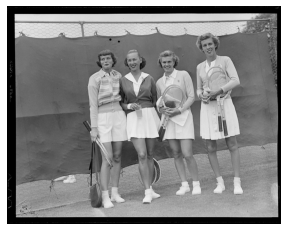

QUESTION
how many people are standing next to each other
MOST COMMON ANSWER
4
PREDICTED ANSWER
yes


In [49]:
print_item_pred(data, model, [131366000], True)